In [1]:
# 1. Loading the excel with survey response
# In this analysis, we will focus on analyzing these survey responses with NLP methods.

#### Importing modules
# for basic dataframe and data arrya functions
import pandas as pd
import numpy as np

# for text pre-processing and model development
import wordcloud  # library to generate wordcloud
from wordcloud import STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA, TruncatedSVD
from sklearn.model_selection import GridSearchCV
import nltk
from nltk.corpus import wordnet, stopwords
from textblob import TextBlob

# for plotting and visualization
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
%matplotlib inline
import seaborn as sns

# for exception handling
import warnings
import re  # library for regular expression

from pprint import pprint

warnings.simplefilter("ignore", DeprecationWarning)

# Read datasets/papers.csv into papers
response = pd.read_csv(
    r'C:\Users\eskaa\OneDrive - Northern Kentucky University\02 RA - Spring 2021\692 Research Work\Data\HealthCarePrivacyPapers.csv', encoding='latin1')
print(response.head())


                                               Title  \
0  A free mailed naloxone program in Philadelphia...   
1  Culture, COVID-19, and collectivism: A paradox...   
2  Privacy paradox in mHealth applications: An in...   
3  The impact of electronic medical record system...   
4  A methodology for selection of a Blockchain pl...   

                                             Content Month    Year  
0  Academic Journal By French, Rachel; Favaro, Ja...   Aug  2020.0  
1  Academic Journal By Webster, Gregory D.; Howel...   Aug  2020.0  
2  Academic Journal By Zhu, Mengxi; Wu, Chuanhui;...   Aug  2020.0  
3  Academic Journal By Barter, Lauren; Cooper, Cu...   Oct  2020.0  
4  Academic Journal By Nanayakkara, Samudaya; Rod...   Sep  2020.0  


In [2]:
def annotate_plot(frame, plot_col, label_col, **kwargs):
    """
    Annotate the plot of a given DataFrame using one of its columns

    Should be called right after a DataFrame or series plot method,
    before telling matplotlib to show the plot.

    Parameters
    ----------
    frame : pandas.DataFrame

    plot_col : str
        The string identifying the column of frame that was plotted

    label_col : str
        The string identifying the column of frame to be used as label

    kwargs:
        Other key-word args that should be passed to plt.annotate

    Returns
    -------
    None

    Notes
    -----
    After calling this function you should call plt.show() to get the
    results. This function only adds the annotations, it doesn't show
    them.
    """

    for label, x, y in zip(frame[label_col], frame.index, frame[plot_col]):
        plt.annotate(label, xy=(x, y), **kwargs)

Year
2016.0     64
2017.0     64
2018.0     71
2019.0     52
2020.0    171
2021.0     86
dtype: int64


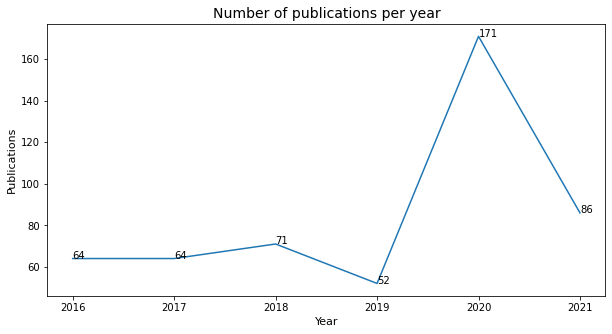

In [3]:
# 3a. Plotting how the opioid research has evolved over time
# A bar plot visualizing the number of publications per year is plotted below
# For this purpose, first the papers are grouped by year and its size is determined
groups = response[response['Year']>2015].groupby('Year')
counts = groups.size()
print(counts)

#x_ticks = papers.groupby('Year').groups.keys()
plt.figure(figsize=(10,5))
ax = counts.plot(kind='line')

for i, j in counts.items():
    ax.annotate(str(j), xy=(i,j))

plt.xlabel('Year', fontsize=11)
plt.ylabel('Publications', fontsize=11)
plt.xticks([2016,2017,2018,2019,2020,2021])
plt.title('Number of publications per year', fontsize=14)
plt.show()

In [4]:
# 3b. Text Pre-processing
my_stopwords = nltk.corpus.stopwords.words('english')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

# Master function to POS tagging
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# Master function to Lemmatization and Stemming
def lemmatize_text(text):
    filtered_text = [word for word in text.split(' ')
                        if word not in my_stopwords] # remove stopwords
    lemmatized_text = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in w_tokenizer.tokenize(' '.join(filtered_text))]
    return ' '.join(lemmatized_text)

response['Title_lemmatized'] = response.Title.apply(lemmatize_text)

# Snowball Stemming
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'

# cleaning master function
# performs text conversion to lowercase, POS tagging & filter and Lemmatization
def clean_response(text, bigrams=False):
    text = text.lower() # lower case
    text = re.sub('['+my_punctuation + ']+', ' ', text) # strip punctuation
    text = re.sub('\s+', ' ', text) #remove double spacing
    text = re.sub('([0-9]+)', '', text) # remove numbers
    text_token_list = [word for word in text.split(' ')
                            if word not in my_stopwords] # remove stopwords

    text_token_list = [word_rooter(word) if '#' not in word else word
                        for word in text_token_list] # apply word rooter
    if bigrams:
        text_token_list = text_token_list+[text_token_list[i]+'_'+text_token_list[i+1]
                                            for i in range(len(text_token_list)-1)]
    text = ' '.join(text_token_list)
    return text

response['Title_processed'] = response.Title_lemmatized.apply(clean_response)

# Master Function for Extracion of Nouns
def extract_nouns(sentence):
    tokens = nltk.word_tokenize(sentence)
    tagged = nltk.pos_tag(tokens)
    length = len(tagged) - 1
    noun_list = list()
    noun_list = [item[0] for item in tagged if item[1][0] == 'N']
    return ' '.join(noun_list)

response['Title_nouns'] = response.Title_lemmatized.apply(extract_nouns)
response.head(10)

,Title,Content,Month,Year,Title_lemmatized,Title_processed,Title_nouns
0,A free mailed naloxone program in Philadelphia...,"Academic Journal By French, Rachel; Favaro, Ja...",Aug,2020.0,A free mail naloxone program Philadelphia amid...,free mail naloxon program philadelphia amidst ...,mail naloxone program Philadelphia COVID-19 pa...
1,"Culture, COVID-19, and collectivism: A paradox...","Academic Journal By Webster, Gregory D.; Howel...",Aug,2020.0,"Culture, COVID-19, collectivism: A paradox Ame...",cultur covid collectiv paradox american excep...,Culture COVID-19 collectivism exceptionalism
2,Privacy paradox in mHealth applications: An in...,"Academic Journal By Zhu, Mengxi; Wu, Chuanhui;...",Aug,2020.0,Privacy paradox mHealth applications: An integ...,privaci paradox mhealth applic integr elabor l...,Privacy mHealth applications elaboration likel...
3,The impact of electronic medical record system...,"Academic Journal By Barter, Lauren; Cooper, Cu...",Oct,2020.0,The impact electronic medical record system im...,impact electron medic record system implement ...,impact record system implementation HCV screen...
4,A methodology for selection of a Blockchain pl...,"Academic Journal By Nanayakkara, Samudaya; Rod...",Sep,2020.0,A methodology selection Blockchain platform de...,methodolog select blockchain platform develop ...,methodology selection Blockchain platform ente...
5,Consumer interaction with cutting-edge technol...,"Academic Journal By Ameen, Nisreen; Hosany, Sa...",Jul,2020.0,Consumer interaction cutting-edge technologies...,consum interact cut edg technolog implic futur...,Consumer interaction cutting-edge technologies...
6,A blockchain empowered and privacy preserving ...,Academic Journal (English) ; Abstract availabl...,Jul,2020.0,A blockchain empower privacy preserve digital ...,blockchain empow privaci preserv digit contact...,blockchain empower privacy contact trace platform
7,Adverse childhood experiences are associated w...,"Academic Journal By: Currie, Cheryl L.; Tough,...",Dec,2020.0,Adverse childhood experience associate illicit...,advers childhood experi associ illicit drug us...,childhood experience drug use woman status Fam...
8,Blockchain-Based Distributed Patient-Centric I...,Academic Journal By: Mohamed Yaseen Jabarulla;...,Aug,2020.0,Blockchain-Based Distributed Patient-Centric I...,blockchain base distribut patient centric imag...,Distributed Patient-Centric Image Management S...
9,Examining actual consumer usage of E-wallet: A...,"Academic Journal By Teng, Shasha; Khong, Kok W...",Aug,2020.0,Examining actual consumer usage E-wallet: A ca...,examin actual consum usag e wallet case studi ...,consumer E-wallet case study data analytics


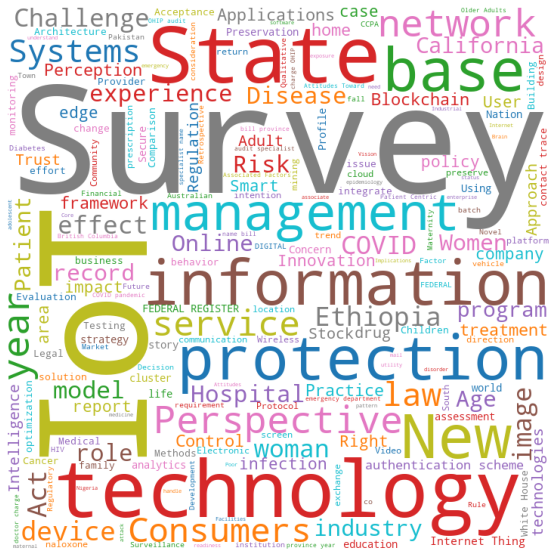

In [5]:
# 3c. Stop Word Filtering and Word Cloud Generation
long_string = " ".join(map(str, response['Title_nouns']))
stopwords = ['privacy','healthcare','security','research','system','use','application','data','health','study','review','method','analysis','consumer','care'] + list(STOPWORDS)
#stopwords = list(STOPWORDS)

# 3d. Generate and visualize a word cloud
wordcloud = wordcloud.WordCloud(stopwords=stopwords, width=720, height=720,background_color="white", colormap="tab10").generate(long_string)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.imshow(wordcloud)
plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

In [6]:
# 4.  Prepare the text for LDA (latent Dirichlet allocation) analysis
# For LDA to work, documents need to be converted to simple vector representation. This will be used by LDA to determine the topics.
# So, we will convert a list of titles into a list of vectors, all with length equal to the vocabulary.
# Each entry of a 'document vector' will correspond with the number of times a word occurred in the document.
# Finally, the 10 most common words are plotted based on the outcome of this operation.
# As a check, these words should also occur in the word cloud.

# Helper function

def plot_n_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts += t.toarray()[0]

    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x: x[1], reverse=True)[0:20]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words))
    
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off

    plt.figure(figsize=(15,10))
    ax = plt.bar(x_pos, counts, align='center')
    
    for p in ax:
        plt.text(p.get_x() + p.get_width()*offset['center'], 1.01*(p.get_height()),
                '{}'.format(p.get_height()), ha=ha['center'], va='bottom')
    
    plt.xticks(x_pos, words, rotation=90)
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.title('20 most common words')
    plt.show()

C:\Users\eskaa\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


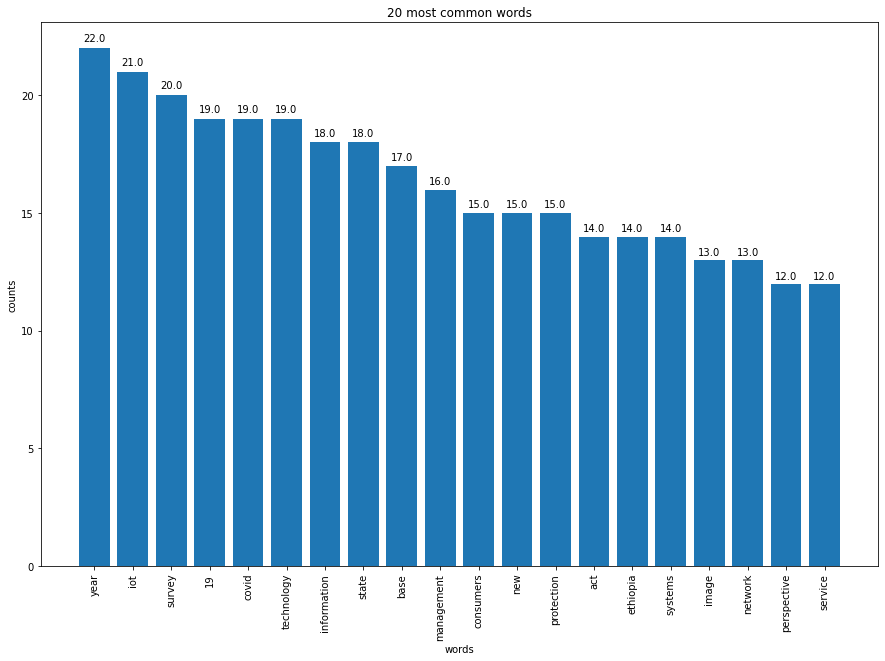

In [7]:
# 4a. Visualise the 30 most common words

vectorizer = CountVectorizer(stop_words=stopwords)
vectorized_data = vectorizer.fit_transform(response['Title_nouns'])
plot_n_most_common_words(vectorized_data, vectorizer)

In [8]:
# 4b. Materialize the sparse data
data_dense = vectorized_data.todense()

# 4b. Compute Sparsity = Percentage of Non-Zero cells
print("Sparsity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsity:  0.3885321320745675 %


In [9]:
# 4c. Analysing trends with LDA
# This step would enable us to identify the number of unique topics using the perplexity factor.

# Helper function

def print_topics(model, vectorizer, n_top_words):
    words = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(", ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

# Tweak the two parameters below (Can use any int values)
number_topics = 20
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit_transform(vectorized_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, vectorizer, number_words)


Topics found via LDA:

Topic #0:
device, risk, effect, control, image, perceived, new, perception, model, look

Topic #1:
industry, information, base, heart, 19, covid, consumers, new, methods, model

Topic #2:
19, covid, pandemic, disease, program, education, naloxone, protection, state, adult

Topic #3:
survey, patient, image, centric, management, architecture, contact, issue, distributed, tracing

Topic #4:
service, systems, company, infection, story, hospital, ethiopia, smart, change, surveillance

Topic #5:
technologies, service, women, framework, blockchain, utility, trend, perspective, protection, patients

Topic #6:
federal, register, law, year, future, industry, australians, poor, associate, report

Topic #7:
iot, house, address, strategy, dubai, gandhi, expat, rahul, stadium, indian

Topic #8:
network, behavior, intention, direction, survey, information, base, secure, edge, user

Topic #9:
year, province, framework, doctor, integrate, nation, name, iot, bill, ohip

Topic #10:

In [10]:
# 4d. Diagnosing the Model Performance through Log Likelihood and Perplpexity factor

# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda.score(vectorized_data))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda.perplexity(vectorized_data))

# See model parameters
print(lda.get_params())

Log Likelihood:  -25650.862305089388
Perplexity:  2532.875226420515
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 20, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': None, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


In [11]:
# 4e. Finding the Best LDA Model through GridSearchCV
# Define Search Param
search_params = {'n_components': [5, 10, 15, 20, 25, 30]}

# Init the Model
search_lda = LDA()

# Init Grid Search Class
model = GridSearchCV(search_lda, param_grid=search_params)

# Do the Grid Search
model.fit(vectorized_data)

# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(vectorized_data))

Best Model's Params:  {'n_components': 5}
Best Log Likelihood Score:  -8273.996265247037
Model Perplexity:  2088.5248225682203


In [12]:
model.cv_results_

{'mean_fit_time': array([0.34296117, 0.30772853, 0.30218778, 0.31275187, 0.31712799,
        0.31688609]),
 'std_fit_time': array([0.0086606 , 0.00332508, 0.00758076, 0.01468221, 0.0059527 ,
        0.01014204]),
 'mean_score_time': array([0.01343966, 0.01256857, 0.01237631, 0.01309953, 0.01376781,
        0.01156464]),
 'std_score_time': array([0.00295851, 0.00161656, 0.00161263, 0.0014967 , 0.00146418,
        0.00101391]),
 'param_n_components': masked_array(data=[5, 10, 15, 20, 25, 30],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_components': 5},
  {'n_components': 10},
  {'n_components': 15},
  {'n_components': 20},
  {'n_components': 25},
  {'n_components': 30}],
 'split0_test_score': array([ -8052.77916638,  -9820.01416025, -11161.22945873, -12293.64519934,
        -13424.41823134, -14698.71206869]),
 'split1_test_score': array([ -9669.11732226, -12495.48936365, -15044.04384262, -17452.1094969

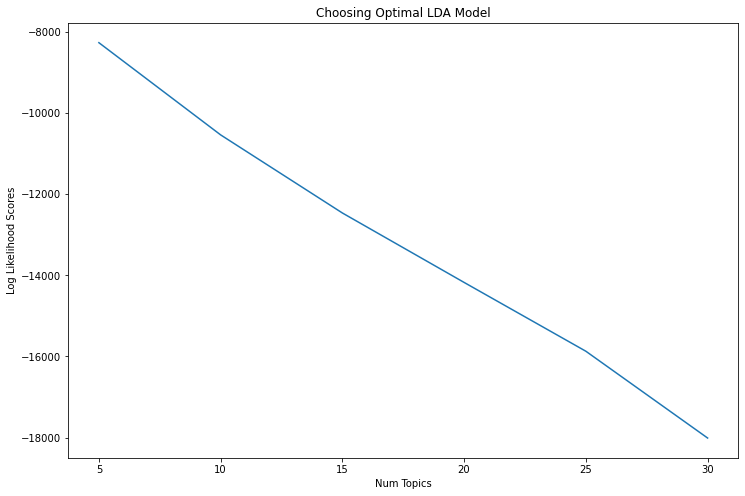

In [13]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [5, 10, 15, 20, 25, 30]
log_likelihood = [round(gscore) for gscore in model.cv_results_['mean_test_score']]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelihood)
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelihood Scores")
plt.show()

In [23]:
#Topics found for the best fit LDA model
print("Topics found for our Best Fit LDA Model:")
print_topics(best_lda_model, vectorizer, 10)

Topics found for our Best Fit LDA Model:

Topic #0:
year, information, act, california, new, protection, hospital, law, name, woman

Topic #1:
covid, 19, systems, survey, technology, network, state, disease, internet, authentication

Topic #2:
iot, record, framework, applications, edge, preservation, service, blockchain, dubai, trace

Topic #3:
federal, experience, home, register, program, women, education, naloxone, 19, covid

Topic #4:
perspective, base, world, role, consumers, management, technology, risk, new, age


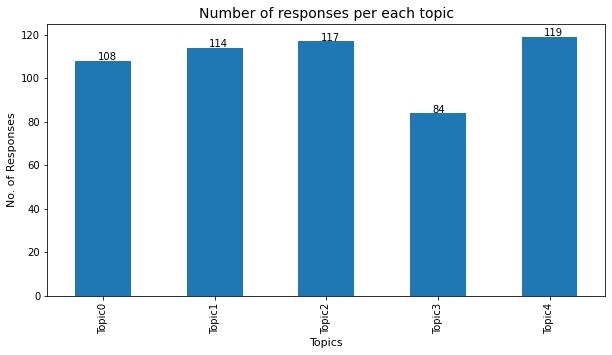

In [14]:
docsPerTopic = best_lda_model.transform(vectorized_data)
docsPerTopic = pd.DataFrame(docsPerTopic, columns=["Topic"+str(i) for i in range(best_lda_model.n_components)])
most_likely_topics = docsPerTopic.idxmax(axis=1)
counts = most_likely_topics.groupby(most_likely_topics).count()

plt.figure(figsize=(10,5))
ax=counts.plot(kind='bar')

for p, label in zip(ax.patches, counts.values):
    ax.annotate(label, (p.get_x()+0.2, p.get_height()+0.3))

plt.xlabel('Topics', fontsize=11)
plt.ylabel('No. of Responses', fontsize=11)
plt.title('Number of responses per each topic', fontsize=14)
plt.show()

In [15]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(vectorized_data)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(response))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.030000,0.030000,0.030000,0.900000,0.030000,3
Doc1,0.030000,0.870000,0.030000,0.030000,0.030000,1
Doc2,0.030000,0.030000,0.030000,0.900000,0.030000,3
Doc3,0.030000,0.030000,0.890000,0.030000,0.030000,2
Doc4,0.030000,0.030000,0.030000,0.030000,0.870000,4
Doc5,0.030000,0.030000,0.870000,0.030000,0.030000,2
Doc6,0.030000,0.030000,0.870000,0.030000,0.030000,2
Doc7,0.900000,0.030000,0.030000,0.030000,0.030000,0
Doc8,0.030000,0.030000,0.030000,0.030000,0.870000,4
Doc9,0.050000,0.050000,0.050000,0.050000,0.800000,4


In [16]:
# review Topic Distribution across documents - same as the bar plot shown above
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,4,118
1,2,117
2,1,114
3,0,109
4,3,84


In [17]:
# Visualize the LDA Model that is selected as the best fit

pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, vectorized_data, vectorizer, mds='tsne')
panel

C:\Users\eskaa\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1      150.222153  -72.269554       1        1  23.117783
4       51.163364 -159.968018       2        1  21.280711
2      -73.144554   21.523815       3        1  20.800780
0      -66.410133 -110.606438       4        1  19.096022
3       54.417324   12.443444       5        1  15.704705, topic_info=            Term       Freq      Total Category  logprob  loglift
742          iot  15.000000  15.000000  Default  30.0000  30.0000
1534        year  15.000000  15.000000  Default  29.0000  29.0000
1362     systems  10.000000  10.000000  Default  28.0000  28.0000
333        covid  13.000000  13.000000  Default  27.0000  27.0000
1             19  13.000000  13.000000  Default  26.0000  26.0000
...          ...        ...        ...      ...      ...      ...
1485       video   1.420304   3.339275   Topic5  -5.8914   0.9963
658        house   1.418795   4.713282   Topic5  -5.8924   0.6506
1191      return   1.417734   3.350721   Topic5  -5.8932   0.9911
1513       white   1.417531   4.041352   Topic5  -5.8933   0.8035
212   challenges   1.416179   4.706353   Topic5  -5.8943   0.6503

[282 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1         1  0.791896          19
1         5  0.143981          19
7         5  0.767970      accept
9         1  0.242040  acceptance
9         2  0.726120  acceptance
...     ...       ...         ...
1525      5  0.407584       women
1530      2  0.874541       world
1531      4  0.742370       worth
1534      2  0.257206        year
1534      4  0.707317        year

[398 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 3, 1, 4])

In [18]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,10,19,2018,abe,abortion,absence,accelerometer,accept,acceptability,acceptance,...,world,worth,wrist,wsn,year,years,yorkshire,youth,zone,zoom
Topic0,0.200004,0.200926,0.206285,0.200011,1.199984,0.200003,0.200005,0.200005,0.200003,0.200010,...,0.200650,3.198756,0.200005,0.200007,16.212548,0.200003,0.200005,0.200014,0.200007,0.200009
Topic1,0.200004,16.125748,0.200009,0.200010,0.200004,0.200002,0.200004,0.200004,1.199988,1.197749,...,0.200011,0.201224,0.200004,0.200007,0.200012,0.200002,1.199979,0.201431,0.200006,1.199967
Topic2,0.200004,0.200937,1.193685,0.201566,0.200004,0.200002,1.199981,0.200005,0.200003,0.200009,...,0.200012,0.200006,1.199981,0.203547,0.201867,0.200002,0.200005,1.199075,0.200006,0.200007
Topic3,0.200005,3.270727,0.200012,1.198402,0.200005,1.199990,0.200006,3.199981,0.200003,0.200012,...,0.200015,0.200008,0.200006,1.196432,0.200015,1.199990,0.200006,0.200017,1.200268,0.200008
Topic4,1.199983,0.201663,0.200009,0.200011,0.200004,0.200002,0.200004,0.200005,0.200003,4.202220,...,9.199312,0.200006,0.200004,0.200007,6.185558,0.200002,0.200005,1.199464,1.199714,0.200008


In [20]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,year,information,act,california,new,protection,hospital,law,name,woman,company,status,cohort,consumers,online
Topic 1,covid,19,systems,survey,technology,network,state,disease,internet,authentication,things,ethiopia,adults,challenge,optimization
Topic 2,iot,record,framework,applications,edge,preservation,service,blockchain,dubai,trace,devices,contact,smart,user,device
Topic 3,federal,experience,home,register,program,women,education,naloxone,19,covid,stocks,industry,center,software,behalf
Topic 4,perspective,base,world,role,consumers,management,technology,risk,new,age,industry,year,policy,rights,approach


In [21]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.38  0.5   0.5   0.25  0.53]
 [-0.07 -0.52 -0.28 -0.02  0.81]]
Perc of Variance Explained: 
 [0.01 0.28]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

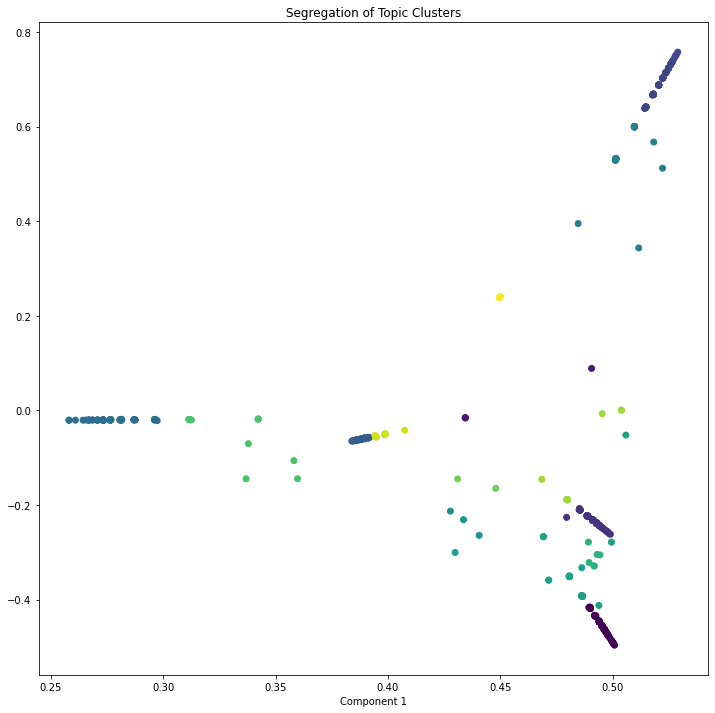

In [22]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )